In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
import pathlib

In [2]:
# Set the path to the parent directory containing class folders
dataset_path = r"D:\Deep Learning project\datatwo"
dataset_dir = pathlib.Path(dataset_path)

In [3]:
# Get class names from subdirectories
class_names = [item.name for item in dataset_dir.iterdir() if item.is_dir()]
print(class_names)

['algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


In [4]:
# Parameter setting
train_batch = 128
val_batch = 128
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)
val_split = 0.2

In [5]:
# Load data for Training
train_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                       validation_split=val_split,
                                                       subset="training",
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=train_batch
                                                      )

Found 1570 files belonging to 7 classes.
Using 1256 files for training.


In [6]:
# Load data for Validation
val_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,                                                            
                                                     validation_split=val_split,                                                            
                                                     subset="validation",                                                     
                                                     seed=123,                                                     
                                                     image_size=(img_height, img_width),                                                     
                                                     batch_size=val_batch                                                           
                                                    )

Found 1570 files belonging to 7 classes.
Using 314 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)
num_classes=len(class_names)

['algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


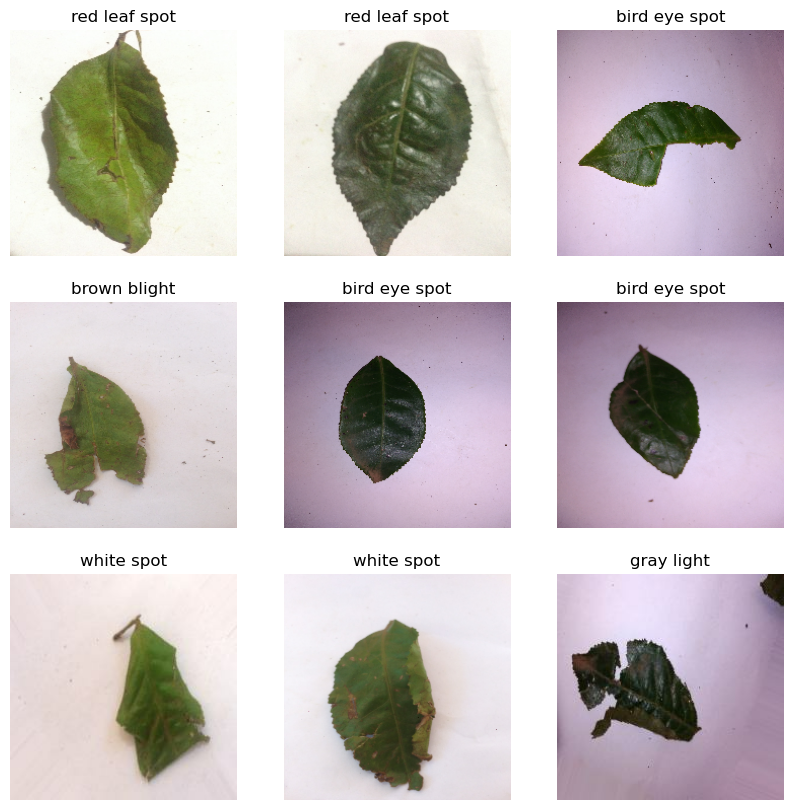

In [8]:
# Review dataset sample
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
## Data augmentation layers to increase data variation for training
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [11]:
from tensorflow.keras.layers import LeakyReLU

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same'),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same'),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same'),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64),
    LeakyReLU(alpha=0.1),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(num_classes, activation='softmax')
])


In [12]:
# compile model
base_learning_rate = 0.0005
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=base_learning_rate,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# display model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                      

In [14]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True)


In [15]:
epochs = 320
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/320


D:\Softwares\anaconda3\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(




10/10 [==============================] - 48s 4s/step - loss: 1.9356 - accuracy: 0.2102 - val_loss: 1.9217 - val_accuracy: 0.2675
Epoch 2/320
10/10 [==============================] - 38s 4s/step - loss: 1.6133 - accuracy: 0.3901 - val_loss: 1.8978 - val_accuracy: 0.4904
Epoch 3/320
10/10 [==============================] - 40s 4s/step - loss: 1.4038 - accuracy: 0.4451 - val_loss: 1.8662 - val_accuracy: 0.3694
Epoch 4/320
10/10 [==============================] - 41s 4s/step - loss: 1.2716 - accuracy: 0.4769 - val_loss: 1.8314 - val_accuracy: 0.3758
Epoch 5/320
10/10 [==============================] - 40s 4s/step - loss: 1.1853 - accuracy: 0.4904 - val_loss: 1.8087 - val_accuracy: 0.5637
Epoch 6/320
10/10 [==============================] - 39s 4s/step - loss: 1.1122 - accuracy: 0.5279 - val_loss: 1.7623 - val_accuracy: 0.4554
Epoch 7/320
10/10 [==============================] - 39s 4s/step - loss: 1.0415 - accuracy: 0.5756 - val_loss: 1.7352 - val_accuracy: 0.4172
Epoch 8/320
10/10 [====

Epoch 56/320
10/10 [==============================] - 40s 4s/step - loss: 0.4721 - accuracy: 0.8272 - val_loss: 0.7000 - val_accuracy: 0.6847
Epoch 57/320
10/10 [==============================] - 39s 4s/step - loss: 0.4784 - accuracy: 0.8121 - val_loss: 0.7216 - val_accuracy: 0.6624
Epoch 58/320
10/10 [==============================] - 40s 4s/step - loss: 0.4630 - accuracy: 0.8097 - val_loss: 0.6543 - val_accuracy: 0.7197
Epoch 59/320
10/10 [==============================] - 39s 4s/step - loss: 0.4668 - accuracy: 0.8105 - val_loss: 0.6345 - val_accuracy: 0.7102
Epoch 60/320
10/10 [==============================] - 39s 4s/step - loss: 0.4419 - accuracy: 0.8256 - val_loss: 0.4745 - val_accuracy: 0.8153
Epoch 61/320
10/10 [==============================] - 40s 4s/step - loss: 0.4337 - accuracy: 0.8280 - val_loss: 0.8355 - val_accuracy: 0.6592
Epoch 62/320
10/10 [==============================] - 40s 4s/step - loss: 0.4503 - accuracy: 0.8201 - val_loss: 0.8583 - val_accuracy: 0.6306
Epoch 

10/10 [==============================] - 41s 4s/step - loss: 0.3049 - accuracy: 0.8846 - val_loss: 0.6393 - val_accuracy: 0.7229
Epoch 114/320
10/10 [==============================] - 40s 4s/step - loss: 0.3381 - accuracy: 0.8702 - val_loss: 0.5496 - val_accuracy: 0.7548
Epoch 115/320
10/10 [==============================] - 40s 4s/step - loss: 0.3340 - accuracy: 0.8750 - val_loss: 0.4716 - val_accuracy: 0.8153
Epoch 116/320
10/10 [==============================] - 40s 4s/step - loss: 0.3361 - accuracy: 0.8734 - val_loss: 0.4214 - val_accuracy: 0.8217
Epoch 117/320
10/10 [==============================] - 40s 4s/step - loss: 0.3151 - accuracy: 0.8734 - val_loss: 0.4319 - val_accuracy: 0.8280
Epoch 118/320
10/10 [==============================] - 41s 4s/step - loss: 0.3263 - accuracy: 0.8646 - val_loss: 0.8030 - val_accuracy: 0.6720
Epoch 119/320
10/10 [==============================] - 39s 4s/step - loss: 0.3297 - accuracy: 0.8750 - val_loss: 0.6261 - val_accuracy: 0.7580
Epoch 120/320

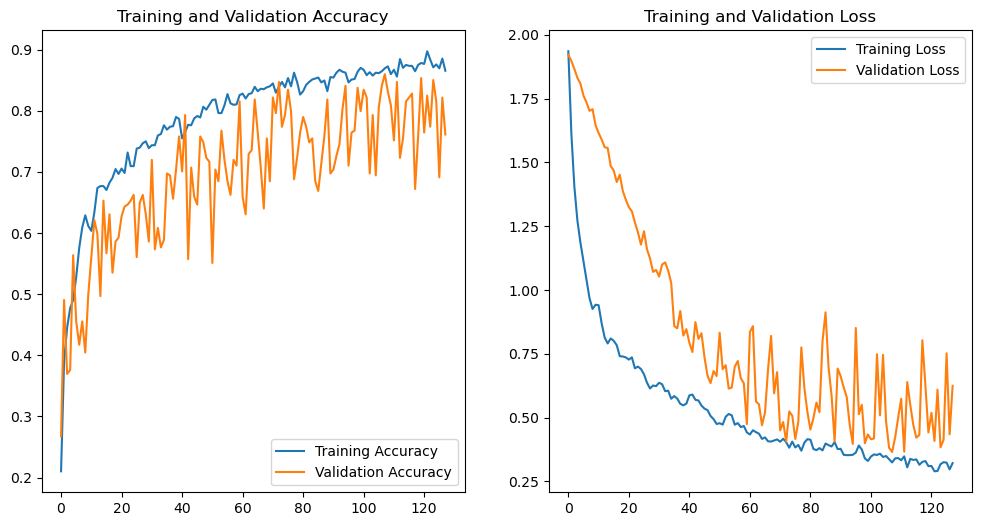

In [16]:
# Check training result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

3/3 [==============================] - 2s 424ms/step


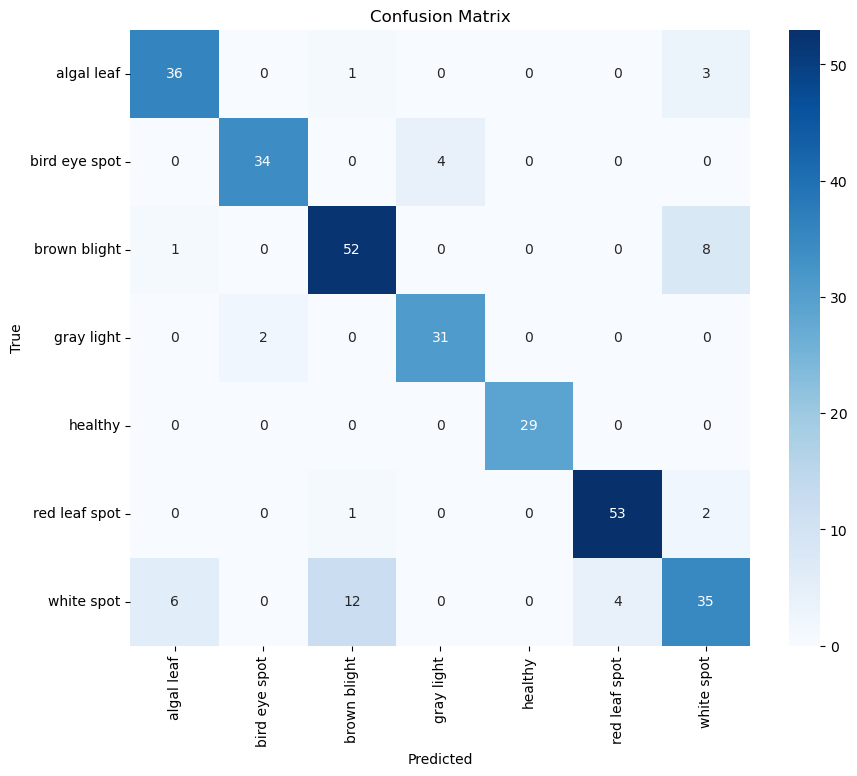

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the validation set
val_predictions = model.predict(val_ds)
val_predictions = np.argmax(val_predictions, axis=1)

# Extract true labels from the validation set
true_labels = []
for _, labels in val_ds:
    true_labels.extend(labels.numpy())

# Create the confusion matrix
conf_mat = confusion_matrix(true_labels, val_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
model.save("D:\Deep Learning project/modelV3_LeakyReLU")

INFO:tensorflow:Assets written to: D:\Deep Learning project/modelV3_LeakyReLU\assets


INFO:tensorflow:Assets written to: D:\Deep Learning project/modelV3_LeakyReLU\assets


Predictions:
 [2 0 4 2 0 2 3 4 1 3 1 2 5 5 0 5 0 5 4 6 6 6 3 2 5 2 4 5 3 2 1 2 2 5 2 5 1
 6 6 6 1 6 2 2 1 2 3 2 4 3 2 5 2 4 3 6 5 2 1 2 1 3 5 5 0 3 2 1 5 2 3 6 5 4
 2 6 3 1 5 5 3 4 2 2 5 0 1 3 3 1 5 5 3 0 2 2 1 0 0 3 4 3 5 0 2 5 6 2 2 3 4
 0 3 0 3 4 2 5 6 0 2 4 6 5 5 2 5 6]
Labels:
 [6 0 4 2 0 2 3 4 1 3 1 6 5 5 0 5 0 5 4 6 6 6 3 2 5 2 4 5 3 2 1 2 2 5 2 5 1
 6 6 6 1 5 2 6 1 2 3 6 4 3 2 5 2 4 3 6 6 2 1 2 1 3 5 5 0 3 2 1 5 2 3 6 5 4
 6 6 3 1 5 5 1 4 2 2 5 0 1 3 3 1 6 5 3 0 2 2 1 0 6 3 4 3 5 6 2 5 6 2 2 3 4
 0 3 0 3 4 2 5 6 0 2 4 6 6 5 2 5 2]

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        11
           1       1.00      0.93      0.96        14
           2       0.84      0.96      0.90        27
           3       0.95      1.00      0.97        19
           4       1.00      1.00      1.00        12
           5       0.88      0.96      0.92        23
           6       0.86      0.55      0.67        22

    accuracy        

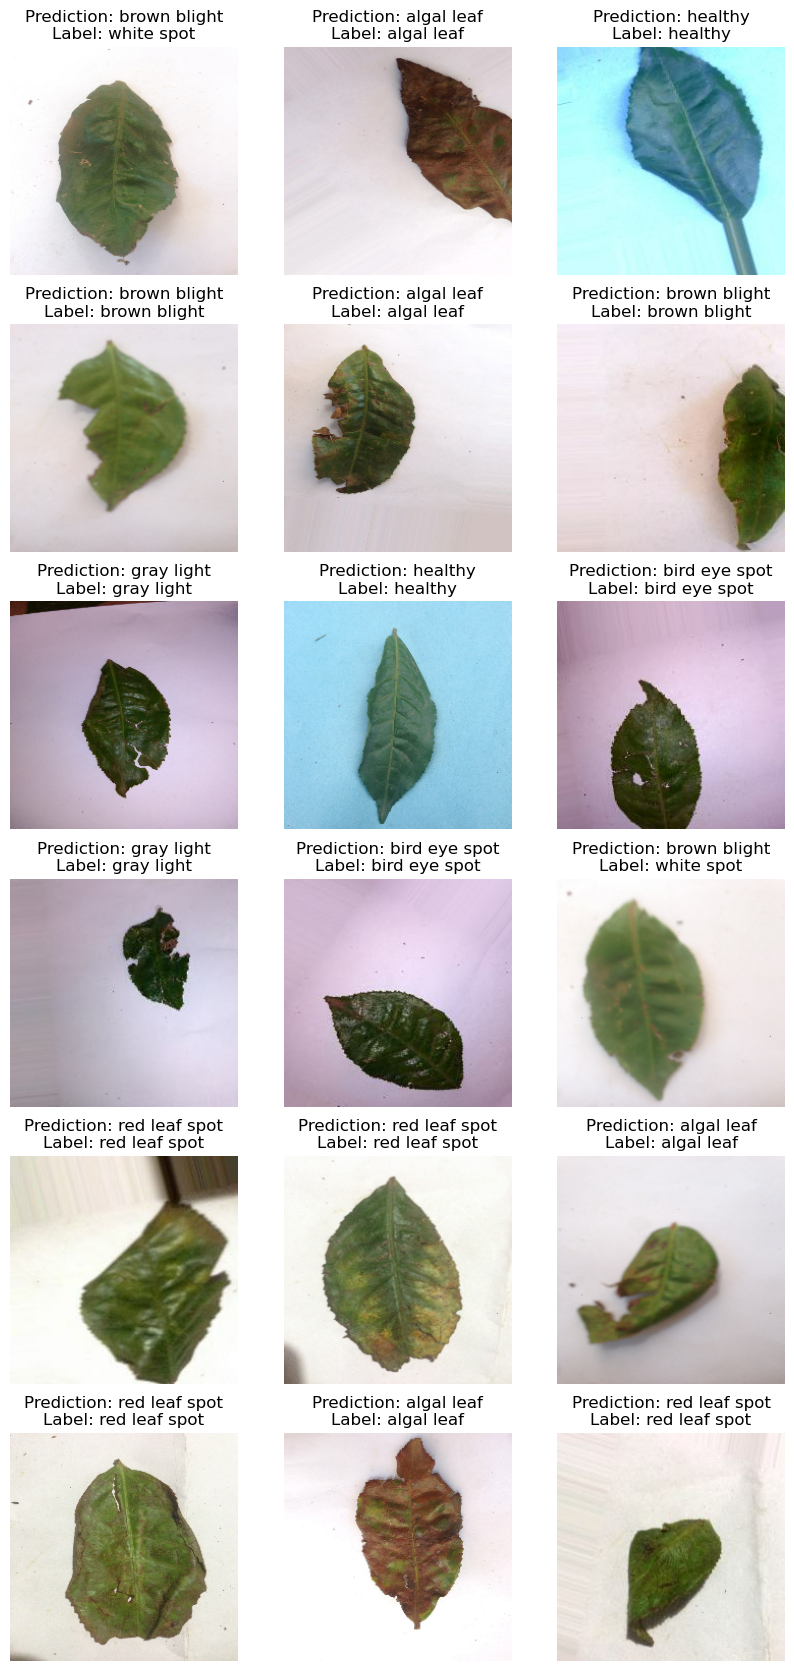

In [18]:
# Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

class_predictions = []
for i in predictions:
    class_prediction = np.argmax(i)
    class_predictions.append(class_prediction)

class_predictions = np.array(class_predictions)
print('Predictions:\n', class_predictions)
print('Labels:\n', label_batch)
print()
print(classification_report(label_batch, class_predictions))

plt.figure(figsize=(10, 21))
for i in range(18):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Prediction: "+class_names[class_predictions[i]]+"\nLabel: "+class_names[label_batch[i]])
    plt.axis("off")

In [20]:
disease_info = {
    'algal leaf': {
        'Cure and Recovery': [
            "Remove affected leaves and destroy them.",
            "Apply a copper-based fungicide to control algal growth.",
            "Adjust irrigation practices to maintain optimal soil moisture."
        ]
    },
    'bird eye spot': {
        'Cure and Recovery': [
            "Prune affected branches to remove infected leaves.",
            "Use copper-based fungicides to control the spread.",
            "Apply organic fungicidal sprays for long-term management."
        ]
    },
    'brown blight': {
        'Cure and Recovery': [
            "Remove and destroy infected leaves promptly.",
            "Apply fungicides containing chlorothalonil.",
            "Adjust irrigation to minimize leaf wetness."
        ]
    },
    'gray light': {
        'Cure and Recovery': [
            "Prune affected branches and dispose of infected leaves.",
            "Use systemic fungicides for better control.",
            "Apply sulfur-based fungicides for organic management."
        ]
    },
    'healthy': {}, 
    'red leaf spot': {
        'Cure and Recovery': [
            "Remove and destroy infected leaves and debris.",
            "Apply fungicides containing mancozeb or copper.",
            "Improve drainage to prevent water stagnation."
        ]
    },
    'white spot': {
        'Cure and Recovery': [
            "Remove and destroy infected leaves promptly.",
            "Apply fungicides containing systemic action.",
            "Improve overall plant health with appropriate fertilization."
        ]
    }
}

1/1 [==============================] - 0s 399ms/step


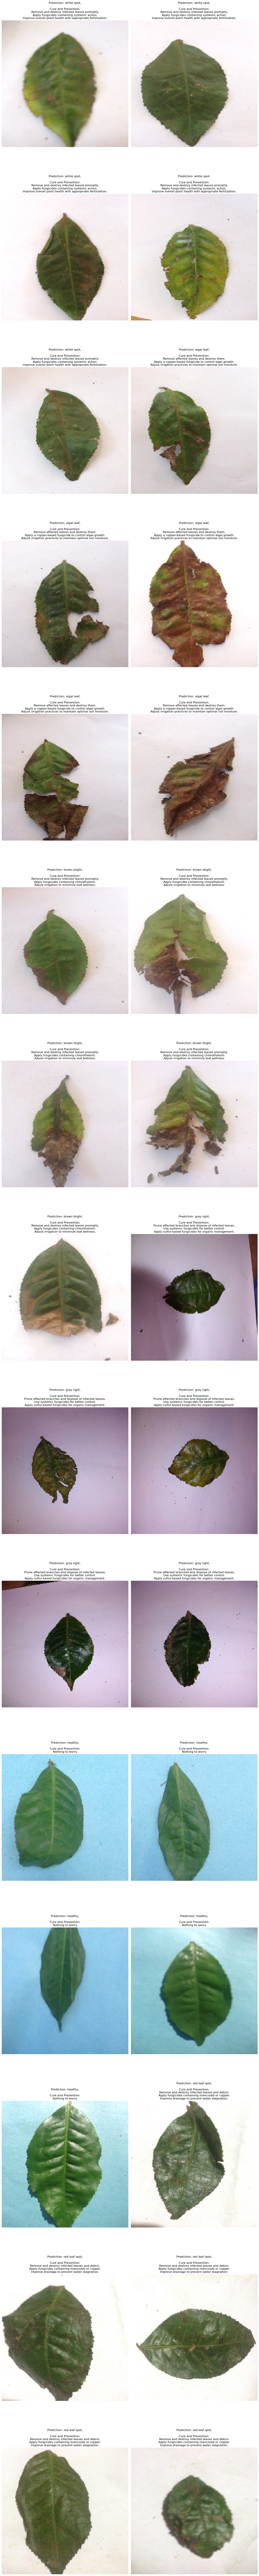

In [21]:
from tensorflow.keras.preprocessing import image


image_paths = [r"D:\Deep Learning project\testimg\w1.jpg",r"D:\Deep Learning project\testimg\w2.jpg",r"D:\Deep Learning project\testimg\w3.jpg", r"D:\Deep Learning project\testimg\w4.jpg", r"D:\Deep Learning project\testimg\w5.jpg", r"D:\Deep Learning project\testimg\a1.jpg",r"D:\Deep Learning project\testimg\a2.jpg",r"D:\Deep Learning project\testimg\a3.jpg", r"D:\Deep Learning project\testimg\a4.jpg", r"D:\Deep Learning project\testimg\a5.jpg", r"D:\Deep Learning project\testimg\b1.jpg",r"D:\Deep Learning project\testimg\b2.jpg",r"D:\Deep Learning project\testimg\b3.jpg", r"D:\Deep Learning project\testimg\b4.jpg", r"D:\Deep Learning project\testimg\b5.jpg", r"D:\Deep Learning project\testimg\g1.jpg",r"D:\Deep Learning project\testimg\g2.jpg",r"D:\Deep Learning project\testimg\g3.jpg", r"D:\Deep Learning project\testimg\g4.jpg", r"D:\Deep Learning project\testimg\g5.jpg", r"D:\Deep Learning project\testimg\h1.jpg",r"D:\Deep Learning project\testimg\h2.jpg",r"D:\Deep Learning project\testimg\h3.jpg", r"D:\Deep Learning project\testimg\h4.jpg", r"D:\Deep Learning project\testimg\h5.jpg", r"D:\Deep Learning project\testimg\r1.jpg",r"D:\Deep Learning project\testimg\r2.jpg",r"D:\Deep Learning project\testimg\r3.jpg", r"D:\Deep Learning project\testimg\r4.jpg", r"D:\Deep Learning project\testimg\r5.jpg"]  # Use raw strings to avoid escape character issues


input_images = []
for img_path in image_paths:
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    input_images.append(img_array)

input_images = np.vstack(input_images)  


predictions = model.predict(input_images)


class_predictions = np.argmax(predictions, axis=1)



plt.figure(figsize=(15, len(image_paths) * 5))
for i in range(len(image_paths)):
    plt.subplot(len(image_paths)//2, 2, i + 1)
    plt.imshow(input_images[i].astype("uint8"))
    predicted_class = class_names[class_predictions[i]]
    cure_recovery_info = "\n".join(disease_info.get(predicted_class, {}).get('Cure and Recovery', ['Nothing to worry']))
    plt.title(f"Prediction: {predicted_class},\n\nCure and Prevention:\n{cure_recovery_info}")
    plt.axis("off")

plt.tight_layout()
plt.show()